<a href="https://colab.research.google.com/github/mgupta004/Rainfall-Prediction-Model/blob/main/Rainfall_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from google.colab import files
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

/tmp/ipython-input-3-1005310116.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
/tmp/ipython-input-3-1005310116.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True

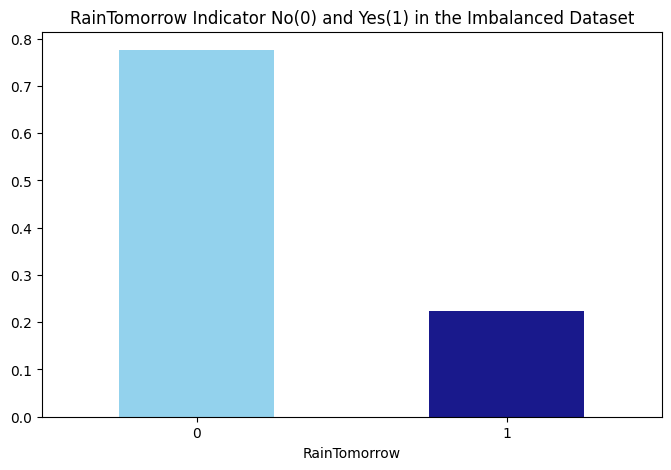

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

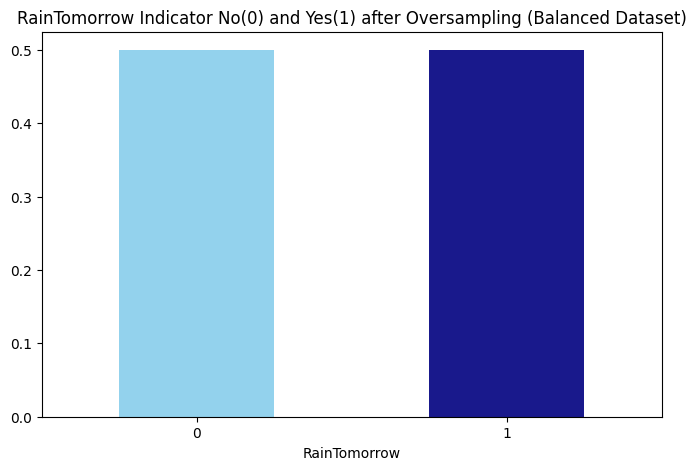

In [5]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

<Axes: >

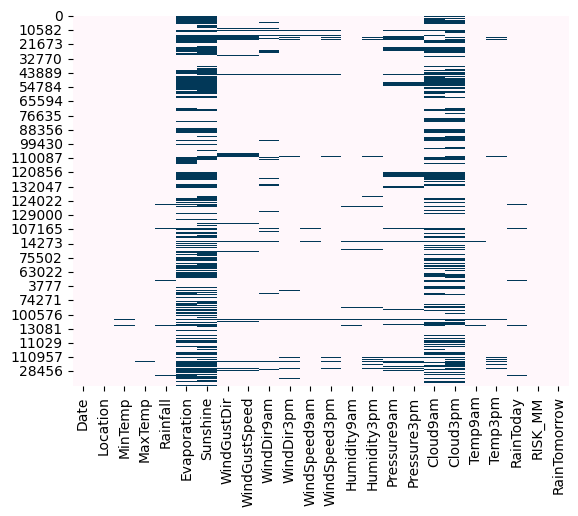

In [6]:
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [7]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [8]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [9]:
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [10]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [12]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [13]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [14]:
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156852, 24)

<Axes: >

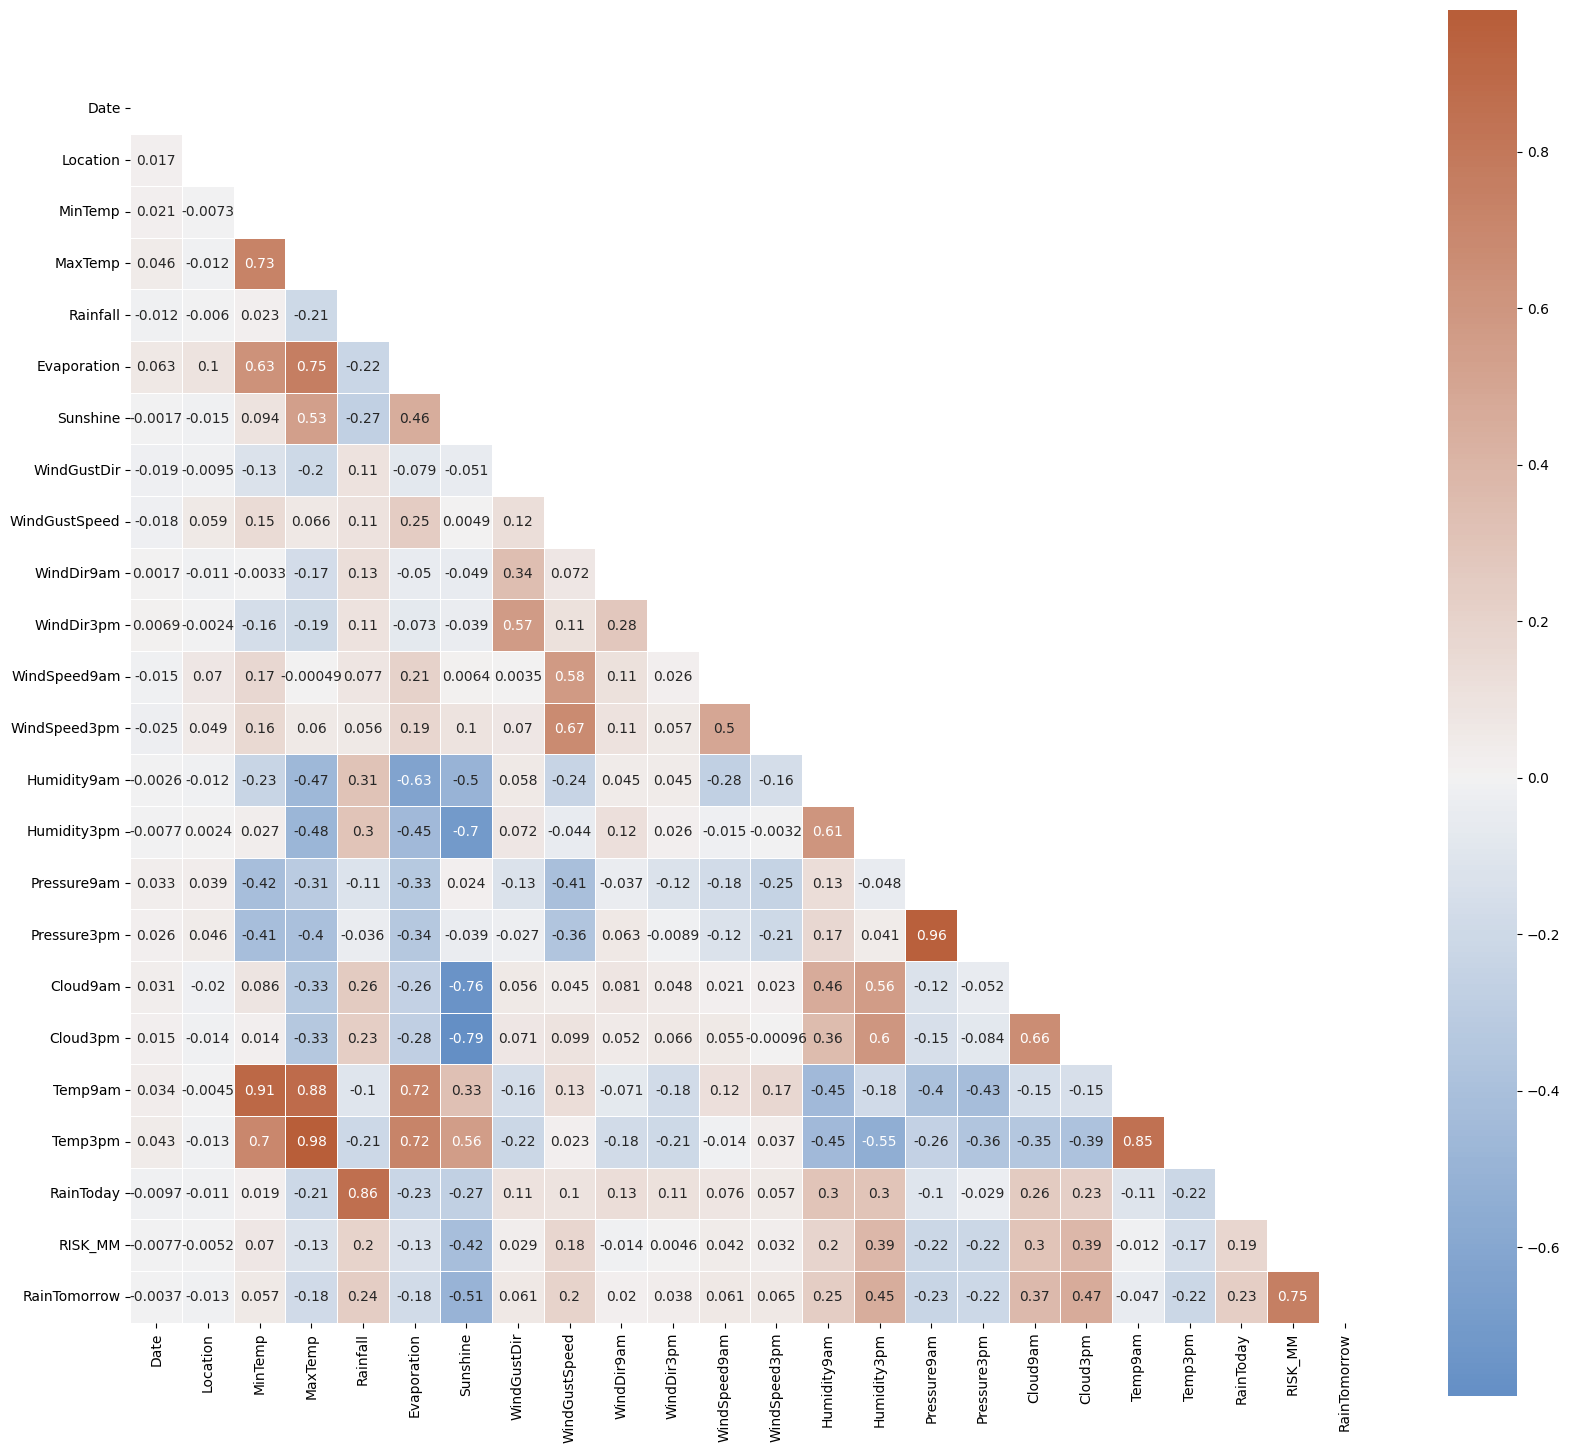

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [17]:
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [18]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


In [19]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [20]:
def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [24]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    cohen_kappa_score,
    roc_curve,
    classification_report,
    ConfusionMatrixDisplay
)

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0 = time.time()
    if not verbose:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t0

    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test, y_pred, digits=5))

    # ROC curve
    probs = model.predict_proba(X_test)[:, 1]
    fper, tper, _ = roc_curve(y_test, probs)
    plot_roc_cur(fper, tper)

    # Confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

    return model, accuracy, roc_auc, coh_kap, time_taken


Accuracy = 0.78963609007217
ROC Area under Curve = 0.76976981489154
Cohen's Kappa = 0.5494516226632338
Time taken = 8.174640893936157
              precision    recall  f1-score   support

           0    0.80822   0.85949   0.83307     23948
           1    0.75520   0.68005   0.71566     15265

    accuracy                        0.78964     39213
   macro avg    0.78171   0.76977   0.77436     39213
weighted avg    0.78758   0.78964   0.78736     39213



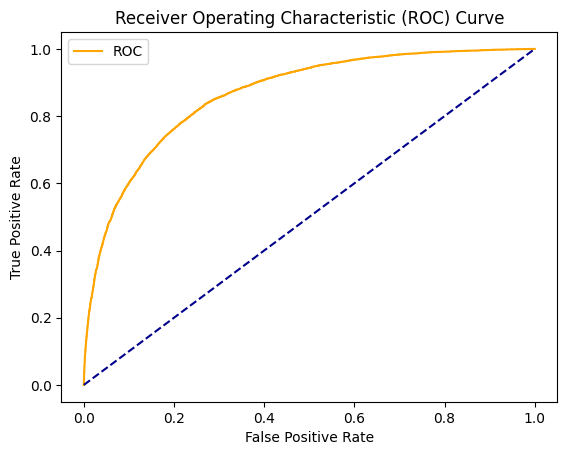

Accuracy = 0.7885650167036442
ROC Area under Curve = 0.7699855158936731
Cohen's Kappa = 0.5483920266787415
Time taken = 0.686234712600708
              precision    recall  f1-score   support

           0    0.81015   0.85389   0.83145     23948
           1    0.74957   0.68608   0.71642     15265

    accuracy                        0.78857     39213
   macro avg    0.77986   0.76999   0.77393     39213
weighted avg    0.78657   0.78857   0.78667     39213



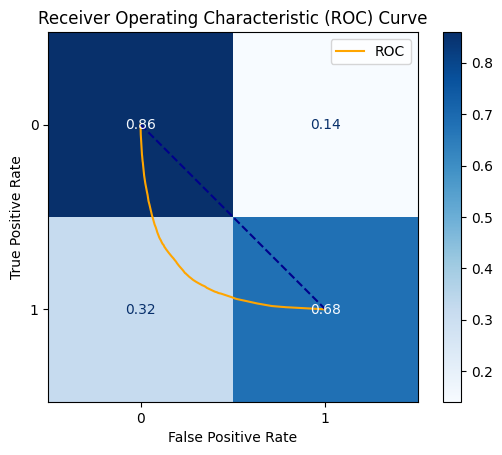

Accuracy = 0.8867212404049677
ROC Area under Curve = 0.8786003682178294
Cohen's Kappa = 0.760669710836645
Time taken = 176.9313292503357
              precision    recall  f1-score   support

           0    0.90083   0.91527   0.90800     23948
           1    0.86365   0.84193   0.85265     15265

    accuracy                        0.88672     39213
   macro avg    0.88224   0.87860   0.88032     39213
weighted avg    0.88636   0.88672   0.88645     39213



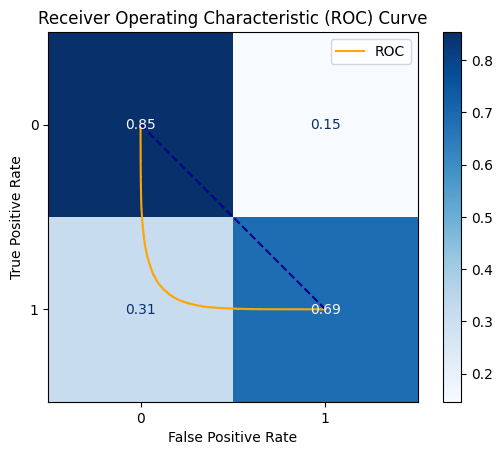

Accuracy = 0.8384464335807003
ROC Area under Curve = 0.8248377940937759
Cohen's Kappa = 0.6566079568354273
Time taken = 12.675896406173706
              precision    recall  f1-score   support

           0    0.85457   0.88630   0.87014     23948
           1    0.81059   0.76338   0.78628     15265

    accuracy                        0.83845     39213
   macro avg    0.83258   0.82484   0.82821     39213
weighted avg    0.83745   0.83845   0.83750     39213



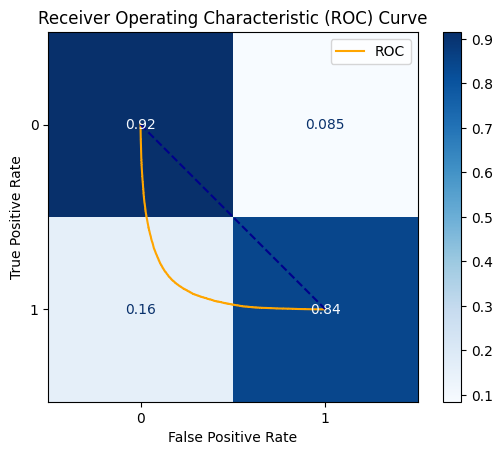

[LightGBM] [Info] Number of positive: 45912, number of negative: 71727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 117639, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390279 -> initscore=-0.446141
[LightGBM] [Info] Start training from score -0.446141
Accuracy = 0.8271491597174406
ROC Area under Curve = 0.8131658636293037
Cohen's Kappa = 0.6327491879085725
Time taken = 2.3314566612243652
              precision    recall  f1-score   support

           0    0.84614   0.87632   0.86096     23948
           1    0.79446   0.75002   0.77160     15265

    accuracy                        0.82715     39213
   macro avg    0.82030   0.81317   0.81628     39213
weighted avg    0.82602   0.82

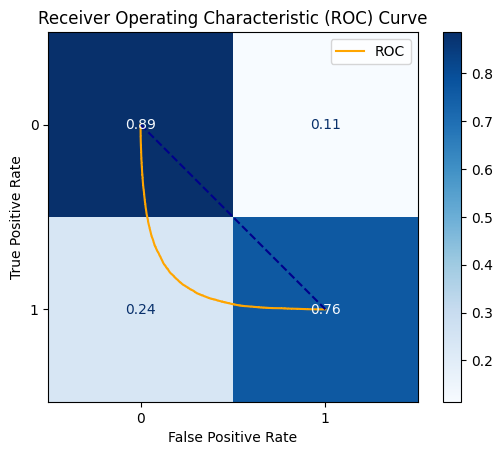

Accuracy = 0.8529059240557978
ROC Area under Curve = 0.8428871423076235
Cohen's Kappa = 0.6891297953422946
Time taken = 3.3898353576660156
              precision    recall  f1-score   support

           0    0.87318   0.88813   0.88059     23948
           1    0.81966   0.79764   0.80850     15265

    accuracy                        0.85291     39213
   macro avg    0.84642   0.84289   0.84455     39213
weighted avg    0.85235   0.85291   0.85253     39213



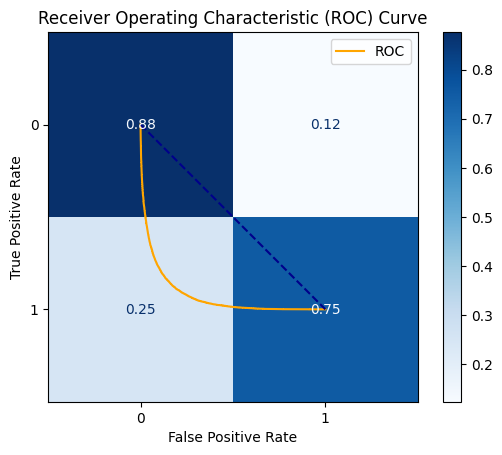

Accuracy = 0.8859306862520082
ROC Area under Curve = 0.880150210541882
Cohen's Kappa = 0.7601469522378643
Time taken = 3.7782552242279053
              precision    recall  f1-score   support

           0    0.90690   0.90626   0.90658     23948
           1    0.85310   0.85405   0.85357     15265

    accuracy                        0.88593     39213
   macro avg    0.88000   0.88015   0.88007     39213
weighted avg    0.88595   0.88593   0.88594     39213



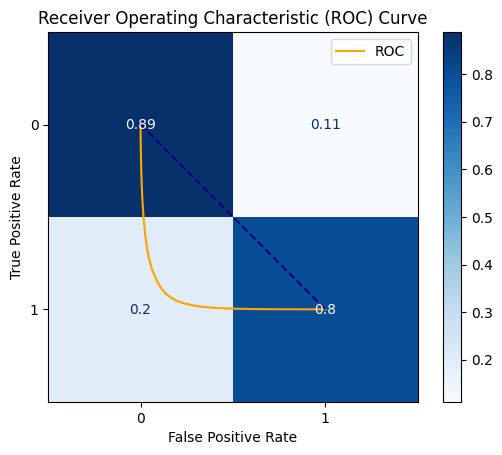

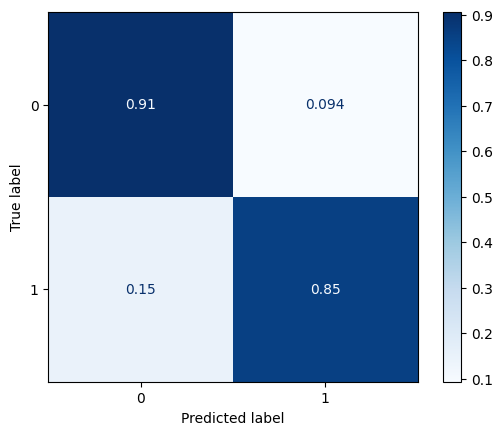

In [30]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver': 'liblinear'}
model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 8, 'max_features': "sqrt"}
model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {
    'hidden_layer_sizes': (30, 30),
    'activation': 'logistic',
    'solver': 'adam',  # faster than lbfgs on large data
    'max_iter': 300,
    'random_state': 42
}
model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split': 4,
    'n_estimators': 50,
    'random_state': 42,
    'n_jobs': -1
}
model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

# LightGBM
import lightgbm as lgb

params_lgb = {
    'colsample_bytree': 0.9,
    'max_depth': 8,
    'min_split_gain': 0.1,
    'n_estimators': 50,
    'num_leaves': 30,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'subsample': 0.9,
    'subsample_freq': 5,
    'random_state': 42
}
model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

# CatBoost
import catboost as cb

params_cb = {
    'iterations': 50,
    'max_depth': 8,
    'verbose': False,
    'random_state': 42
}
model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

# XGBoost
import xgboost as xgb

params_xgb = {
    'n_estimators': 50,
    'max_depth': 8,
    'n_jobs': -1,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}
model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)


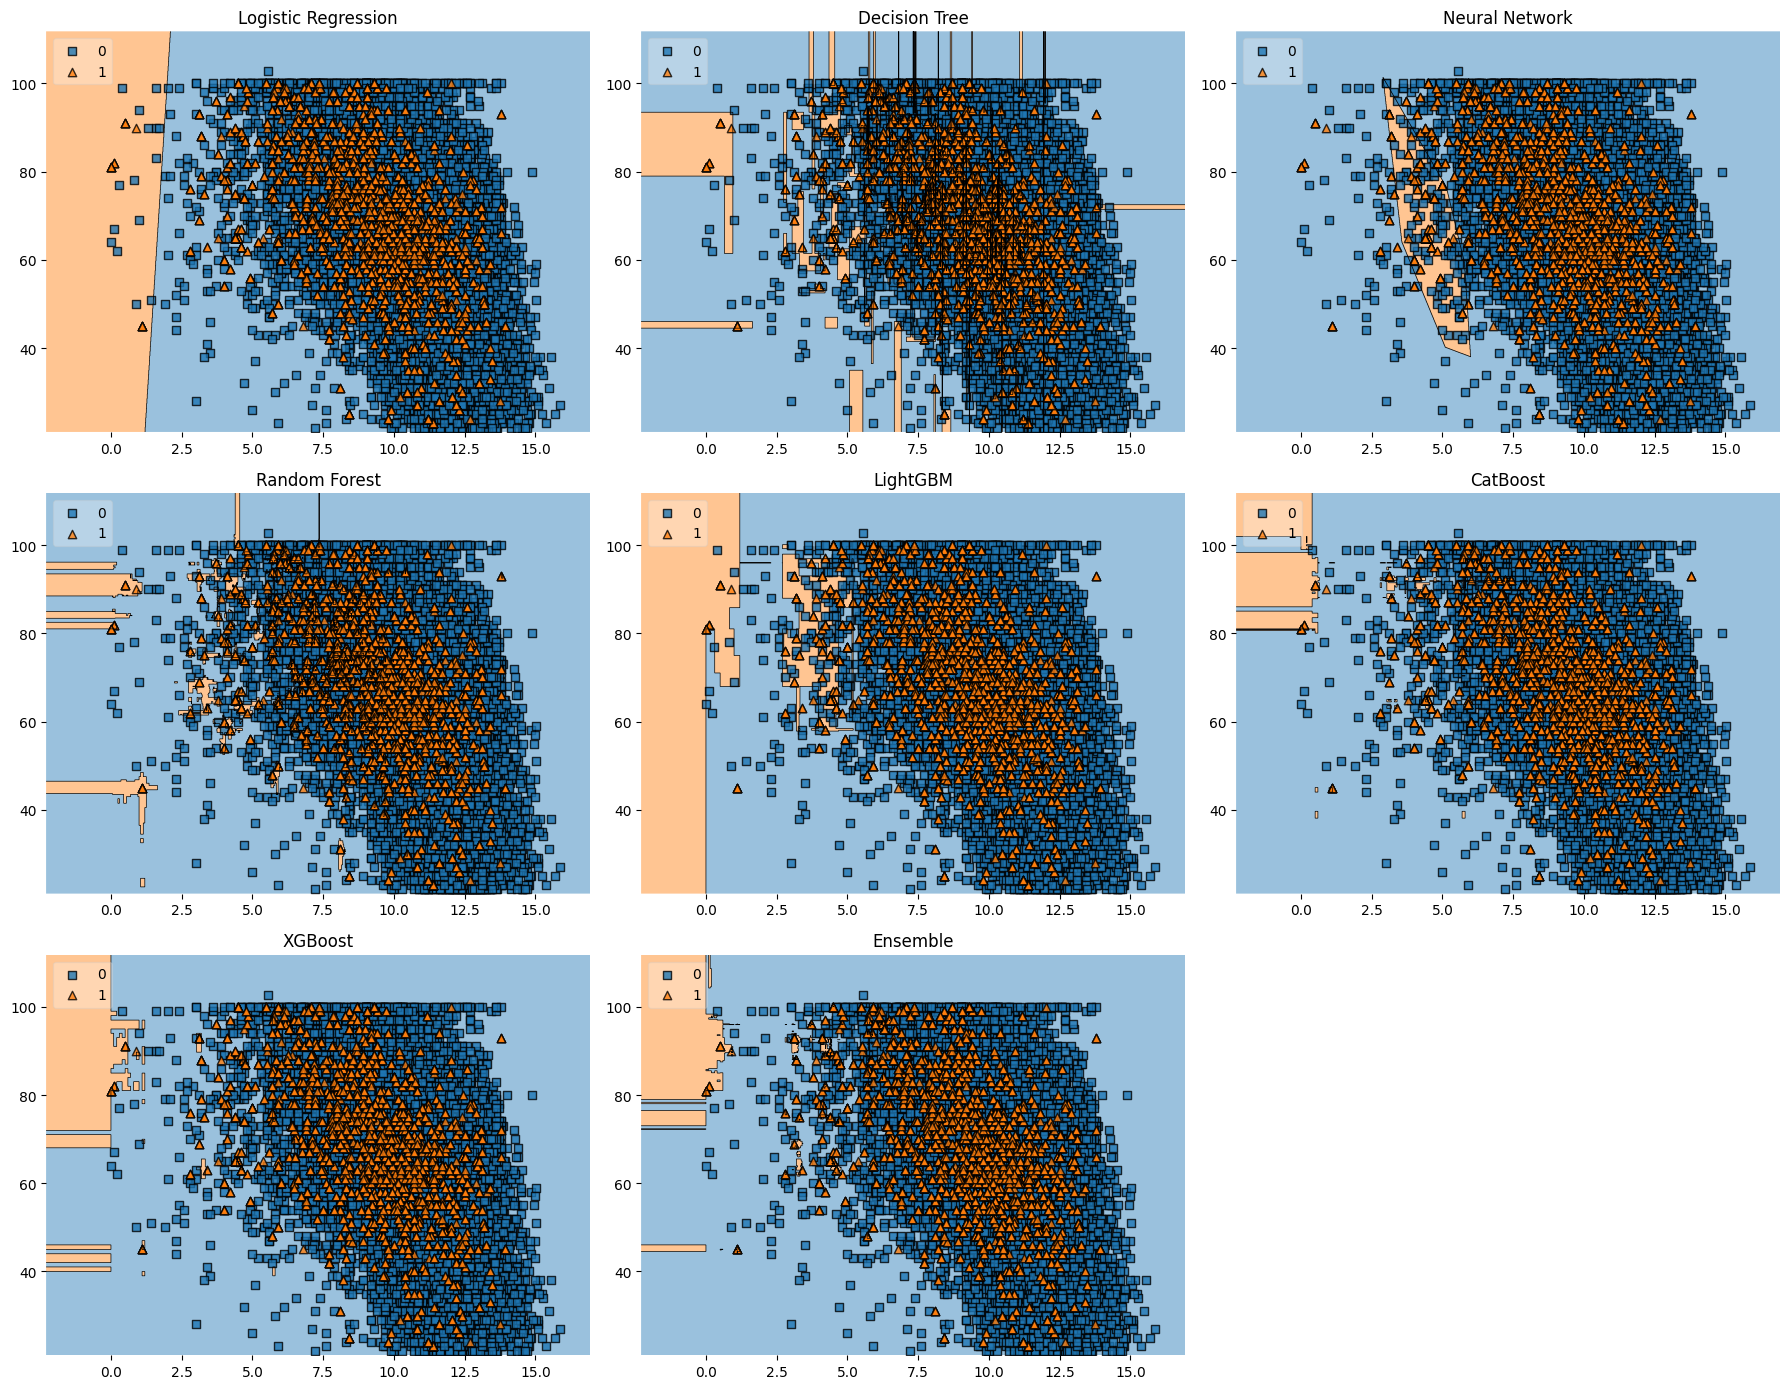

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

# Select key features
X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]]
X = np.asarray(X_list, dtype=np.float64)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=int)

# Classifiers
clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345)
clf3 = MLPClassifier(random_state=12345, max_iter=300)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose=-1)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose=0)
clf7 = xgb.XGBClassifier(random_state=12345, use_label_encoder=False, eval_metric='logloss')

# Ensemble
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

# Plotting
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression', 'Decision Tree', 'Neural Network',
          'Random Forest', 'LightGBM', 'CatBoost', 'XGBoost', 'Ensemble']

for clf, lab, grd in zip(
    [clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
    labels,
    itertools.product([0, 1, 2], repeat=2)
):
    ax = plt.subplot(gs[grd[0], grd[1]])
    clf.fit(X, y)
    plot_decision_regions(X=X, y=y, clf=clf,
                          filler_feature_values={2: 1.8},
                          filler_feature_ranges={2: 0.9},
                          legend=2, ax=ax)
    ax.set_title(lab)

plt.tight_layout()
plt.show()


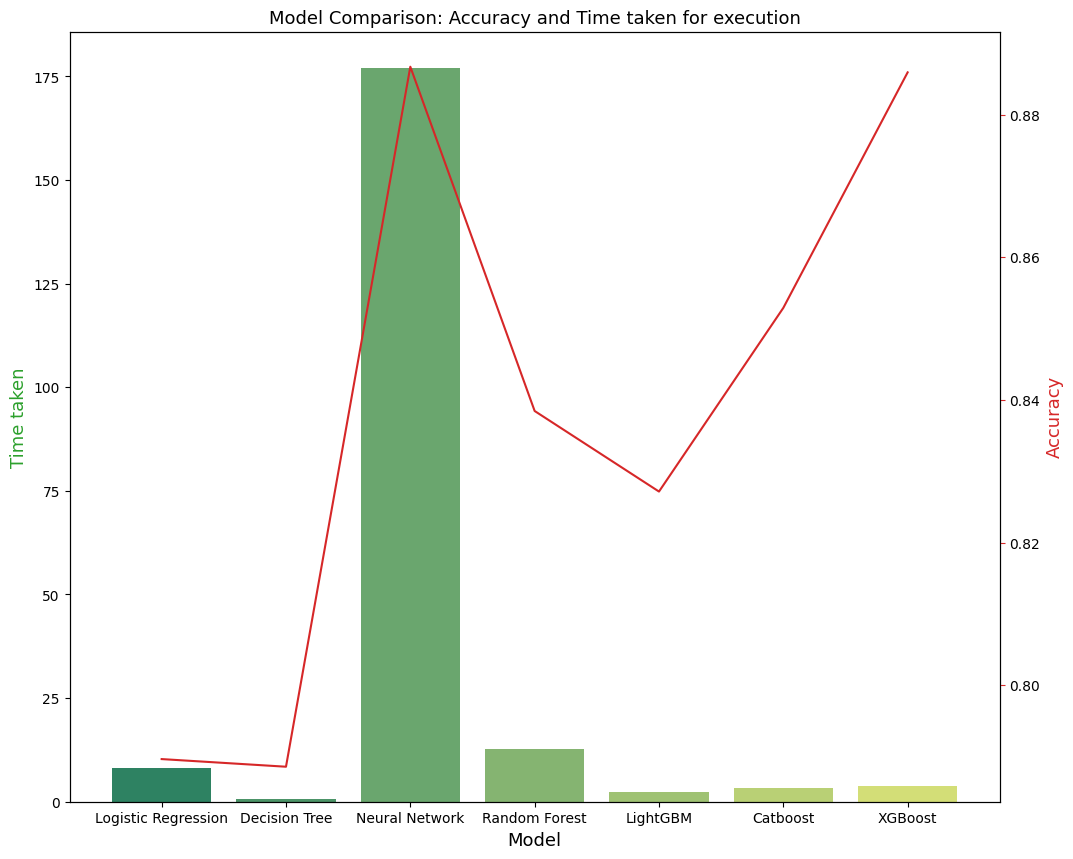

In [33]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

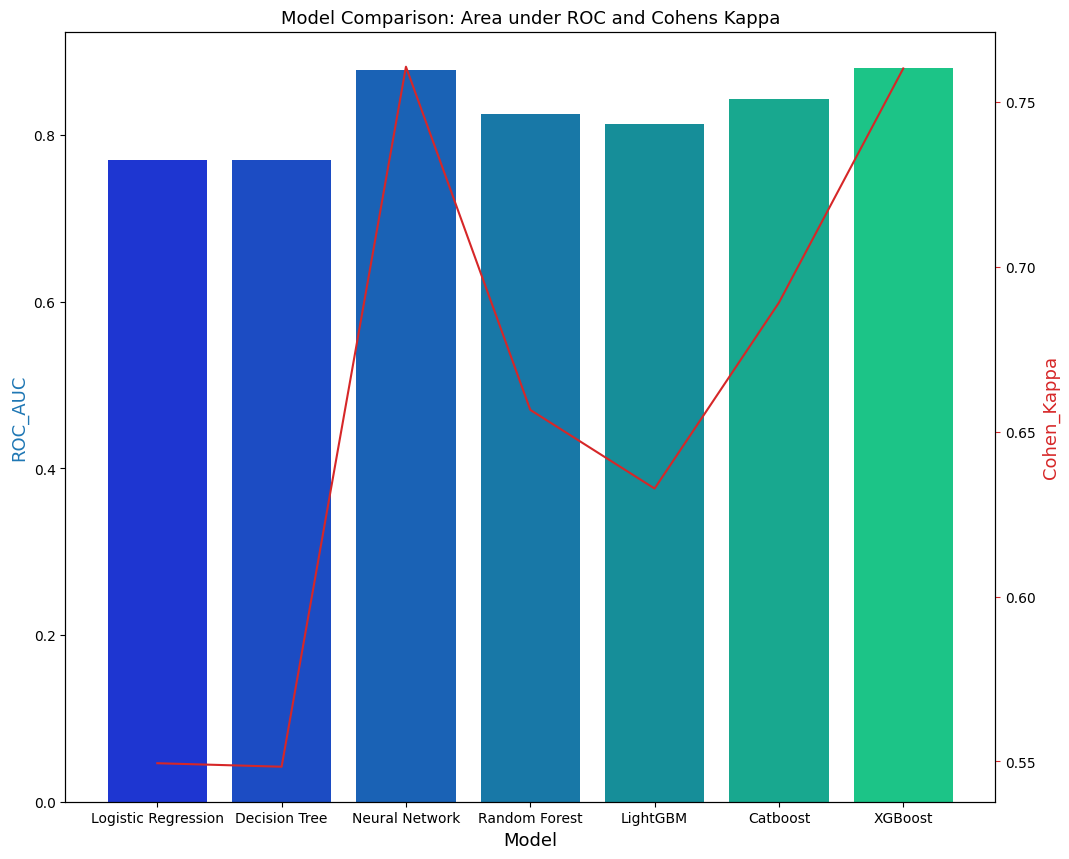

In [34]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()